# 04 – Results and Visualizations
Train with best params and visualize metrics.

Test ROC-AUC: 0.9738
PR AUC: 0.7557

Classification report (0.5 threshold):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.86      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.92      0.61     56962
weighted avg       1.00      0.99      0.99     56962


Confusion Matrix:
 [[56287   577]
 [   14    84]]


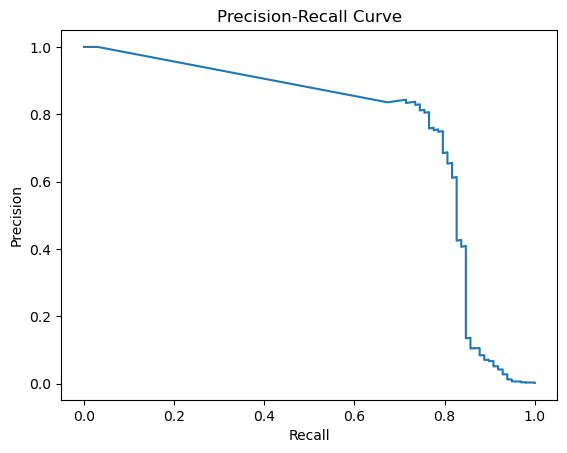

In [7]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv(Path('../data/raw/creditcard.csv'))
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cols_to_scale = ['Amount'] + (['Time'] if 'Time' in X.columns else [])
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Replace with the best result printed by the tuning notebook
best = dict(n_estimators=177.99726, max_depth=4.9293377, max_features=0.8929409, min_samples_split=12.820070, min_samples_leaf=7.3726532)
clf = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    max_features=float(best['max_features']),
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba)

from sklearn.metrics import precision_recall_curve, auc
prec, rec, thr = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)

print('Test ROC-AUC:', round(roc, 4))
print('PR AUC:', round(pr_auc, 4))
print('\nClassification report (0.5 threshold):\n', classification_report(y_test, (proba>=0.5).astype(int)))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, (proba>=0.5).astype(int)))

plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.show()

In [8]:
import joblib, pathlib
pathlib.Path('../models').mkdir(exist_ok=True)
joblib.dump(clf, '../models/fraud_rf.pkl')

['../models/fraud_rf.pkl']

In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def pick_threshold(y_true, p, min_precision=0.50):
    grid = np.linspace(0.01, 0.99, 99)
    rows = []
    for t in grid:
        y_pred = (p >= t).astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        rows.append((t, prec, rec, f1))
    # choose highest recall among thresholds meeting min precision; fallback to best F1
    cand = [r for r in rows if r[1] >= min_precision]
    best = max(cand, key=lambda r: r[2]) if cand else max(rows, key=lambda r: r[3])
    return {"threshold": best[0], "precision": best[1], "recall": best[2], "f1": best[3]}

best_thr = pick_threshold(y_test, proba, min_precision=0.50)
best_thr

{'threshold': 0.8200000000000001,
 'precision': 0.5031055900621118,
 'recall': 0.826530612244898,
 'f1': 0.6254826254826255}

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

t = float(best_thr["threshold"])  # ~0.82
y_pred = (proba >= t).astype(int)

print(f"Chosen threshold: {t:.2f}")
print("Precision:", round(best_thr["precision"],4),
      "Recall:", round(best_thr["recall"],4),
      "F1:", round(best_thr["f1"],4))

print("\nClassification report (chosen threshold):")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(cm)
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}")

Chosen threshold: 0.82
Precision: 0.5031 Recall: 0.8265 F1: 0.6255

Classification report (chosen threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.83      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.91      0.81     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56784    80]
 [   17    81]]

TN=56784, FP=80, FN=17, TP=81


PR AUC: 0.7557


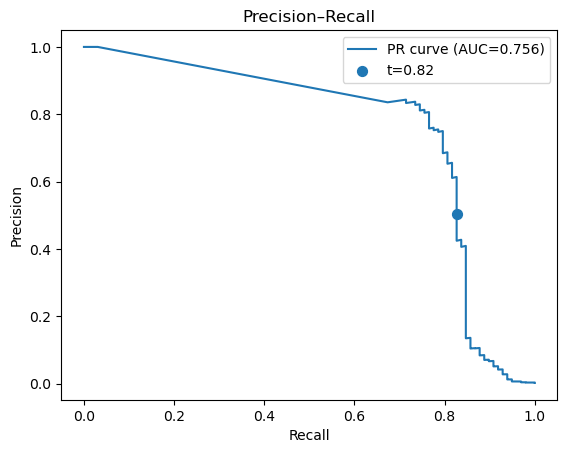

<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.metrics import precision_recall_curve, auc
prec, rec, thr = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)
print("PR AUC:", round(pr_auc,4))

import numpy as np, matplotlib.pyplot as plt
plt.figure()
plt.plot(rec, prec, label=f'PR curve (AUC={pr_auc:.3f})')

# Mark the chosen threshold on the curve (closest thr)
if len(thr) > 0:
    idx = (np.abs(thr - t)).argmin()
    plt.scatter(rec[idx], prec[idx], s=50, label=f't={t:.2f}')

plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall')
plt.legend(); plt.show()

plt.savefig("../docs/pr_curve.png", bbox_inches="tight", dpi=160)

In [12]:
import json, pathlib
pathlib.Path("../models").mkdir(exist_ok=True)
artifact = {"best_params": best, "threshold": float(t)}
with open("../models/fraud_rf_artifact.json", "w") as f:
    json.dump(artifact, f, indent=2)
print("Saved ../models/fraud_rf_artifact.json")

Saved ../models/fraud_rf_artifact.json


In [19]:
from pathlib import Path

p = Path('../docs/pr_curve.png').resolve()
print(p)            # shows the exact location it tried to save
print(p.exists())   # True means the file exists there

C:\Users\dell\Downloads\ML_Portfolio_Fraud_Detection\ML_Portfolio_Fraud_Detection\docs\pr_curve.png
True
